In [35]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [36]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'])


In [37]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [38]:
sales_a = sales_a.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_a.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,54555,2738080,177316
1,2019-02-01,54293,4637013,300290
2,2019-03-01,58798,7079920,458491
3,2019-04-01,53229,3744057,242463
4,2019-05-01,50558,4196578,271768


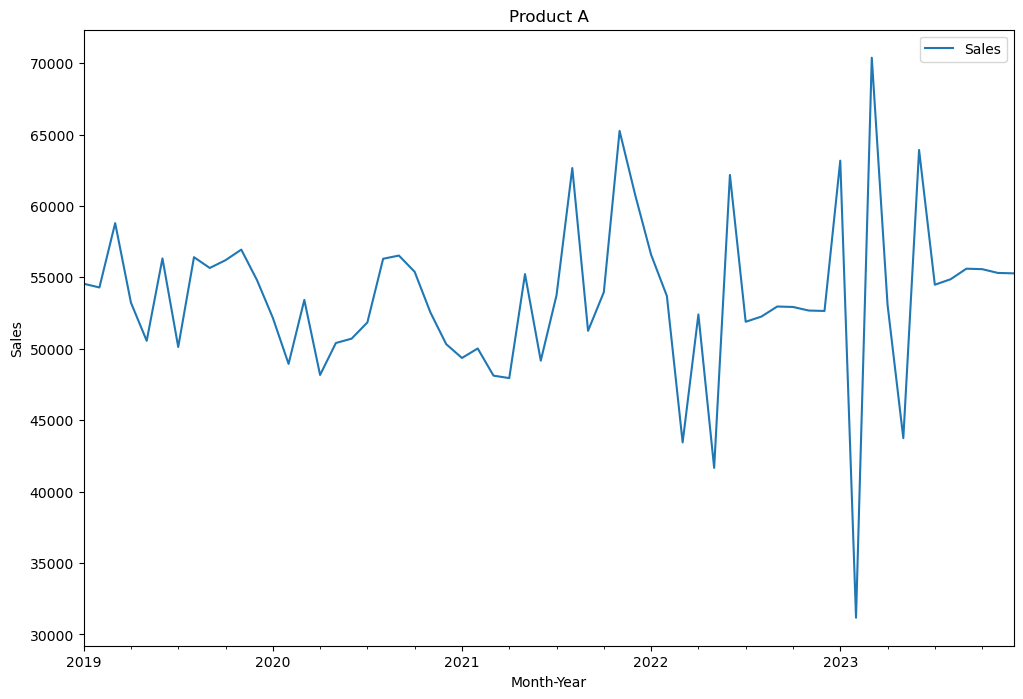

In [39]:
ax = sales_a.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product A')
plt.legend(['Sales'])
plt.show()


In [40]:
train= sales_a[:54]
test=sales_a[54:]

In [41]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing
21:02:08 - cmdstanpy - INFO - Chain [1] start processing
21:02:09 - cmdstanpy - INFO - Chain [1] done processing
21:02:14 - cmdstanpy - INFO - Chain [1] start processing
21:02:14 - cmdstanpy - INFO - Chain [1] done processing
21:02:19 - cmdstanpy - INFO - Chain [1] start processing
21:02:19 - cmdstanpy - INFO - Chain [1] done processing
21:02:24 - cmdstanpy - INFO - Chain [1] start processing
21:02:25 - cmdstanpy - INFO - Chain [1] done processing
21:02:29 - cmdstanpy - INFO - Chain [1] start processing
21:02:30 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:38 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:47 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0    9291.908086  
1    9364.638753  
2    9215.676568  
3    9268.613983  
4    9202.067664  
..       

In [42]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
20,0.010,5.00,additive,9110.633994
22,0.010,10.00,additive,9115.675881
6,0.001,3.00,additive,9124.649431
16,0.010,1.00,additive,9126.370644
18,0.010,3.00,additive,9127.619367
...,...,...,...,...
49,0.300,0.01,multiplicative,11253.770679
60,0.500,0.01,additive,11383.556985
61,0.500,0.01,multiplicative,11458.087646
70,0.500,10.00,additive,12262.273077


In [43]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


In [44]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=5.0,seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [45]:
model.fit(train)

21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:53 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [47]:
future_dates['Market Size'] = sales_a['Market Size']
future_dates['Marketing Expense'] = sales_a['Marketing Expense']

In [48]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [49]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [50]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [51]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,50507.258976,41685.444257,59732.557318
55,2023-08-01,56762.751862,47496.195963,66247.073880
56,2023-09-01,55913.705093,47034.220375,65389.746618
57,2023-10-01,56124.190051,46998.489035,64620.227331
58,2023-11-01,60246.352778,50942.839006,69616.085204
59,2023-12-01,54014.410877,44967.413252,63459.797691


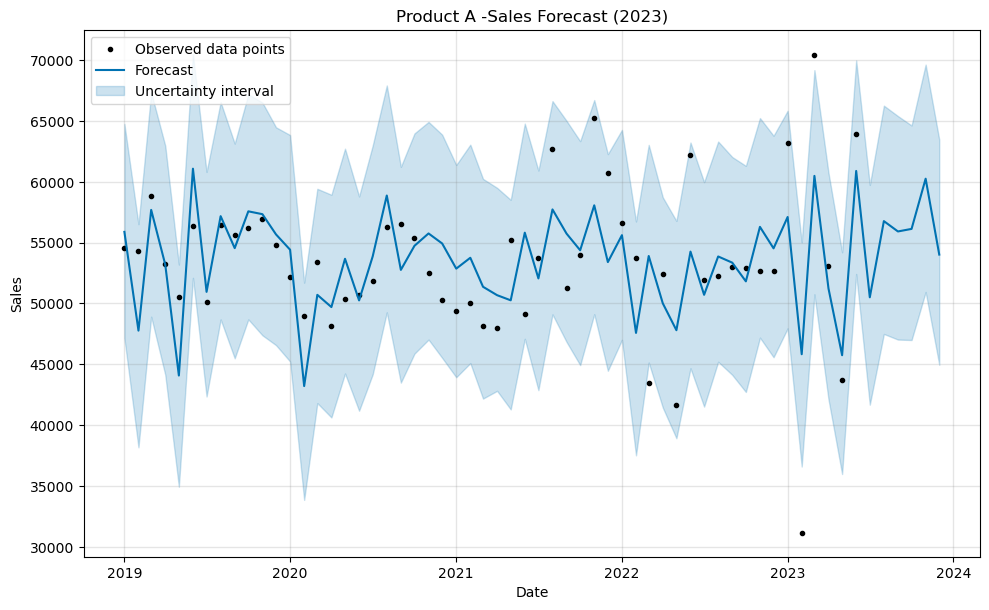

In [52]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

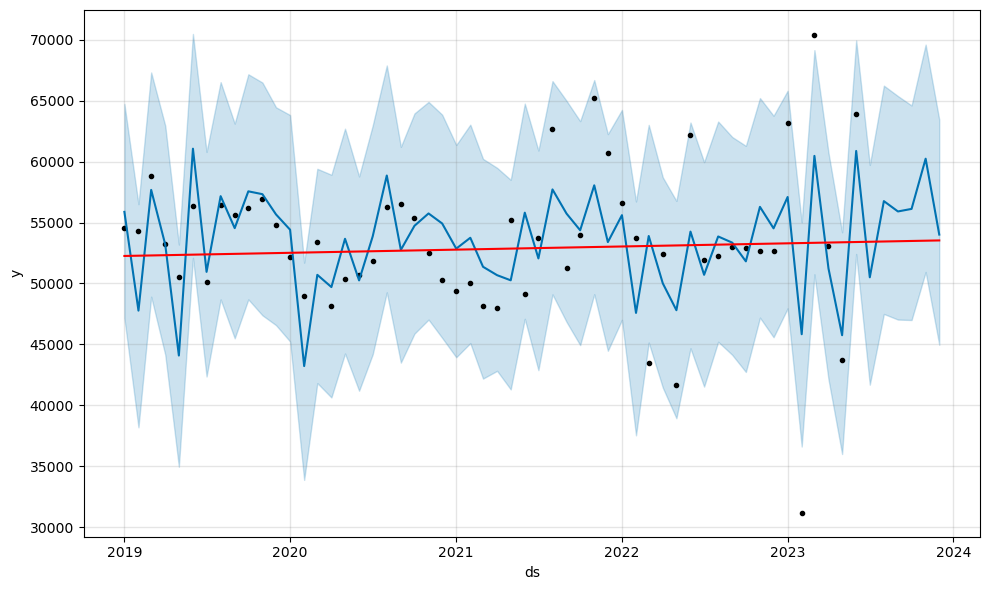

In [53]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

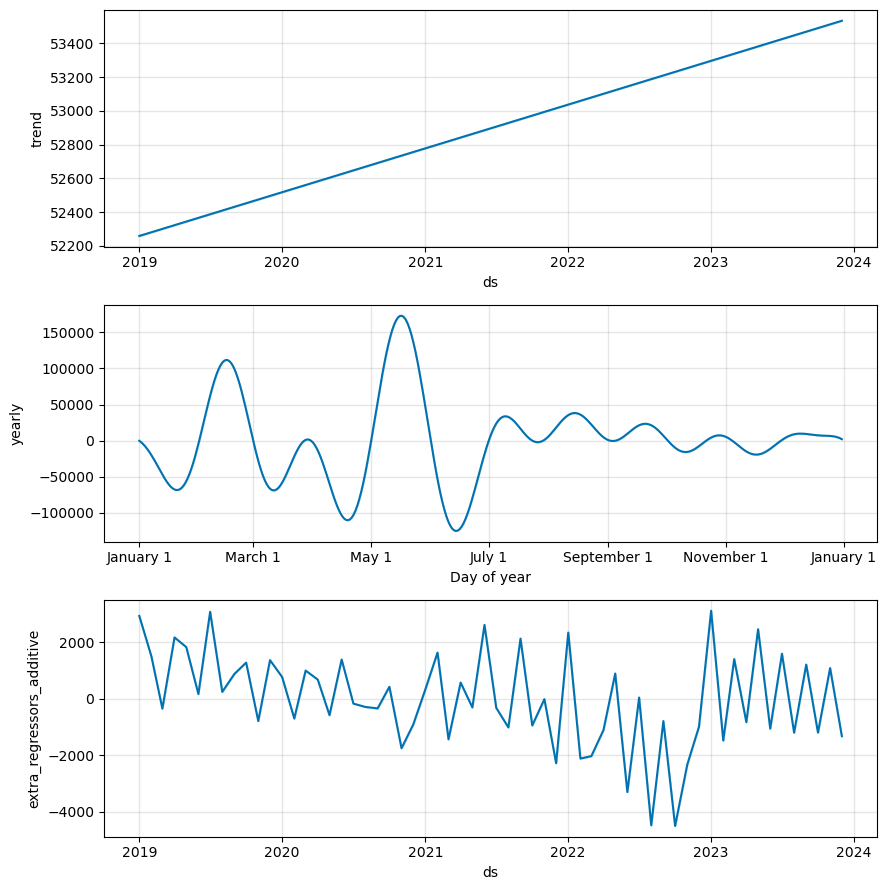

In [54]:
fig2 = model.plot_components(forecast)

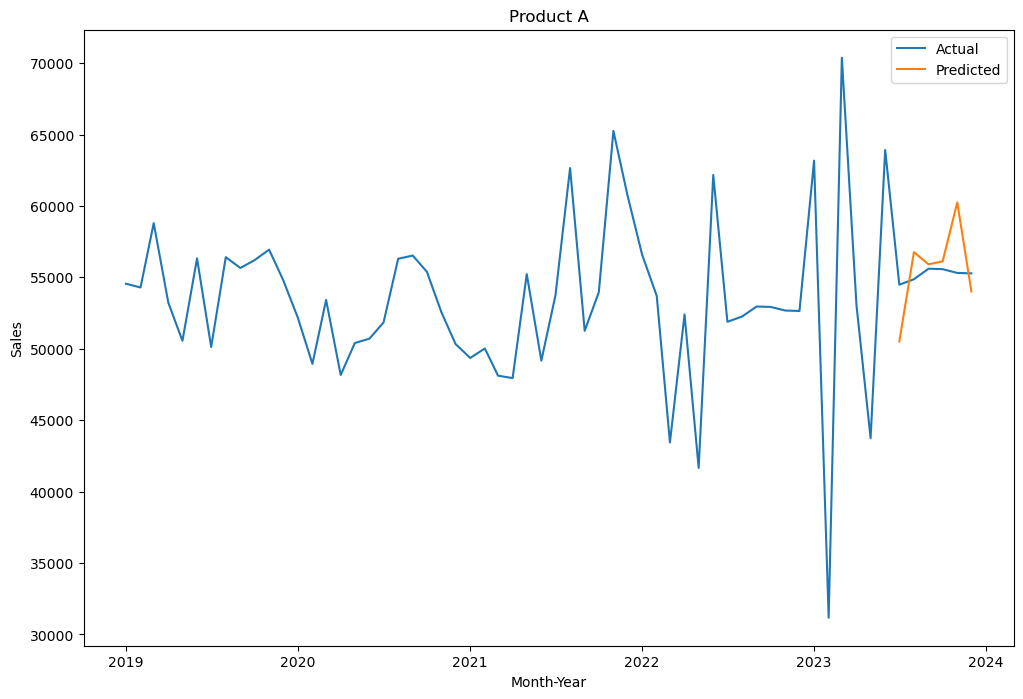

In [55]:
# Reset index of sales_b DataFrame
sales_a_reset_index = sales_a.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_a_reset_index['ds'], sales_a_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product A')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [56]:
#model evaluation

In [57]:
pred=forecasted_df['yhat']
test_df=test['y']

In [58]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 2154.888
MAPE - FB PROPHET: 0.039
MSE - FB PROPHET: 7627725.423
RMSE - FB PROPHET: 2761.834


In [59]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [60]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,1.477223e+07,3843.466041,2824.270900,0.052615,0.052615,0.055299,0.5
1,61 days,7.855332e+07,8863.031041,8851.625965,0.154619,0.154619,0.154588,0.0
2,92 days,4.302081e+06,2074.145873,2073.495466,0.039820,0.039820,0.039041,1.0
3,122 days,1.775893e+07,4214.135061,3523.804892,0.066358,0.066358,0.063606,1.0
4,153 days,1.122984e+08,10597.091602,9762.168202,0.159916,0.159916,0.169863,0.5
5,183 days,6.929766e+07,8324.521883,6997.416695,0.118371,0.118371,0.127741,0.5
6,214 days,8.631785e+07,9290.739952,9253.566524,0.154244,0.154244,0.167152,0.0
7,245 days,3.833231e+08,19578.638193,16424.192566,0.488138,0.488138,0.359611,0.0
8,273 days,2.292642e+08,15141.471651,13432.969361,0.219260,0.219260,0.238752,0.0
9,304 days,3.320150e+07,5762.074703,5734.638800,0.108805,0.108805,0.110380,0.5


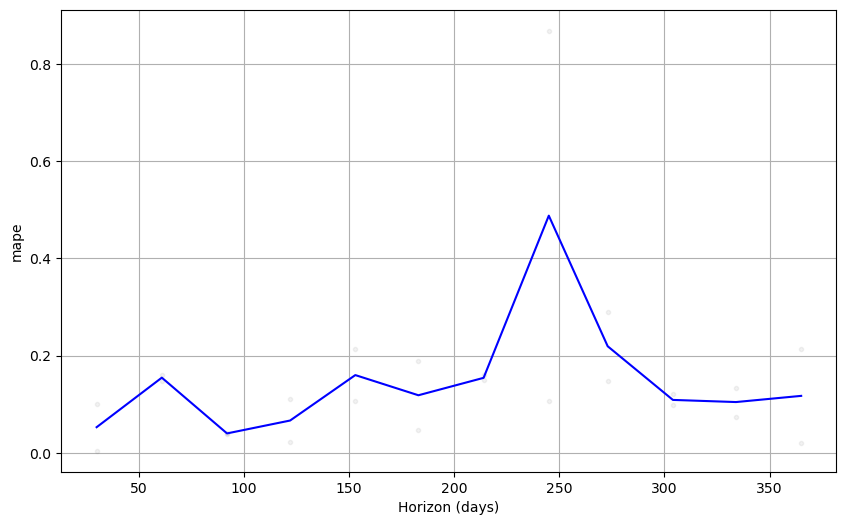

In [61]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [62]:
test_df

54    54485
55    54869
56    55607
57    55575
58    55311
59    55281
Name: y, dtype: int64

In [63]:
pred

54    50507.258976
55    56762.751862
56    55913.705093
57    56124.190051
58    60246.352778
59    54014.410877
Name: yhat, dtype: float64